# Mini Lab : SVM and Logistic Regression modeling
### Laura Ahumada, Kevin Boyd, Shikha Pandey, Duy Nguyen
##### Southern Methodist University
##### Fall, 2022

In [25]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express

In [26]:
# Get current directory
os.path.dirname(os.path.realpath('__file__'))

# Import file
df=pd.read_csv("adult.csv")

In [27]:
df.shape

(32561, 15)

In [28]:
#Looking at the data
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### Missing Values
+ We do see missing values in workclass, occupation and native.country entered as "?". 

+ Despite the "?" values taking around 5% of their respective columns "workclass", "occupation", "native.country", they were not removed due to the following reason. Census data is collected by census-takers knocking on doors and will either ask or let citizens volunteeringly write down the answer of questions about their workclass, occupation and native country, and the people may not want to report those 3 things to the government. However their incomes were still reported so it's best to treat those missing values as another category and replace them with "Unknown".


In [29]:
# Verify missing values for categorical variables 
counter=[]
vals=[]
for i in df.select_dtypes(object).columns:
    vals.append(str(((df[df[i].str.len()<2])[i]).unique()))
    counter.append((df[df[i].str.len()<2].count())[i])
    
# creating df and filtering    
d = {'Column': df.select_dtypes(object).columns, 'MissingValues': counter}
missing=pd.DataFrame(data=d)
print(set(vals))
missing[missing["MissingValues"]==1]


{'[]', "['?']"}


,Column,MissingValues


In [30]:
# Replacing question marks (?) with "Unknown"
df[['workclass','occupation','native.country']] = df[['workclass','occupation','native.country']].replace({'?':'Unknown'})

In [31]:
# 24 rows are duplicate, they will be kept since it makes sense as this is a sensus
df[df.duplicated()]["age"].count()

24

# Logistic Regression

In [32]:
#Loading libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit

In [33]:
#Deleting native_country due to the amount of variable
for i in ["native.country","education"]:
    df=df.drop(i, axis=1)
#Change to bool
df['income_bool'] = df["income"]=='>50K' 
#Changing our target to 0 and 1
df['income_bool']= df.income_bool.astype(int)

In [34]:
#Changing the categorical variables to dummys

#Getting all continuous variables
df_continuous = df.select_dtypes(exclude=['object'])
#Getting all the categorical variables
df_discrete = df.select_dtypes(exclude=['int64'])
#dropping our target
df_discrete=df_discrete.drop("income", axis=1)
#putting the data together 
df_discrete_dum = pd.get_dummies(df_discrete)
df_new = pd.concat([df_continuous, df_discrete_dum], axis = 1)

In [35]:
# Setting the X and Y
Y = df_new['income_bool'].values 
X= df_new.drop("income_bool", axis=1).values
#random splitting
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [36]:
# Creating Training and Testing split
num_cv_iterations =3

cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
for train_indices, test_indices in cv_object.split(X,Y): 
    x_train = X[train_indices]
    y_train = Y[train_indices]
    
    x_test = X[test_indices]
    y_test = Y[test_indices]

## Logistic Regression model

#### Logistic with L2 
+ Training and testing score of 79% 

In [37]:
# Run the model with L2
model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object
model.fit(x_train, y_train)  

#predicting on the data
y_predict = model.predict(x_test)

##Getting scores
trainM = model.score(x_train,y_train)
print("Model TRAINING Score:", trainM)
testM = model.score(x_test, y_test)
print("Model TESTING Score:", testM)



Model TRAINING Score: 0.7988713144963145
Model TESTING Score: 0.7936434822662367


#### Logistic with cross validation 
+ Same results of 79%

In [38]:
# Running model with cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(model, X, y=Y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[0.79794258 0.79732842 0.80224167]


#### We modified the cost from 0 to 7 
+ There wasn't much change, it ranged between 79% to 80%

In [39]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None,solver='liblinear') # get object
    accuracies = cross_val_score(lr_clf,X,y=Y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,7.0,0.05),__manual=True)

interactive(children=(FloatSlider(value=3.451, description='cost', max=7.0, min=0.001, step=0.05), Output()), …

<function __main__.lr_explor(cost)>

#### Logistic regression scaling the data
+ The accuracy score having the data scaled ***increased*** from 79% to 85% 

In [40]:

from sklearn.preprocessing import StandardScaler
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(x_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

x_train_scaled = scl_obj.transform(x_train) # apply to training
x_test_scaled = scl_obj.transform(x_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
model2= LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
model2.fit(x_train_scaled,y_train)  # train object

y_hat = model2.predict(x_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )



accuracy: 0.8486104713649624
[[4608  322]
 [ 664  919]]


#### Using L1 on scaled data
+ Accuracy decreased by a few decimals than when using l2. 
+ The accruacy was 85.15 while L2 lead 85.18% accuracy


In [41]:
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score
model3= LogisticRegression(penalty='l1', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
model3.fit(x_train_scaled,y_train)  # train object

y_hat = model3.predict(x_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('Train Accuracy:', accuracy_score(y_train, model3.predict(x_train_scaled) ))
print('Test Accuracy:', acc )
print(conf )



Train Accuracy: 0.8532324938574939
Test Accuracy: 0.8475356978350991
[[4609  321]
 [ 672  911]]


#### Using elasticnet
+ Using Elasticnet penalty which is used for big data lead to the same accuracy of 85% and gave a warning that the coef did not converge 

In [42]:
# train the model just as before
model4= LogisticRegression(penalty='elasticnet', C=0.05, solver='saga',l1_ratio=1) # get object, the 'C' value is less (can you guess why??)
model4.fit(x_train_scaled,y_train)  # train object

y_hat = model4.predict(x_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('Train Accuracy:', accuracy_score(y_train, model4.predict(x_train_scaled) ))
print('Test accuracy:', acc )
print(conf )

Train Accuracy: 0.8533860565110565
Test accuracy: 0.8475356978350991
[[4610  320]
 [ 673  910]]


/Users/lauraahumada/opt/anaconda3/envs/smuenv/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


#### We see that there hasn't been much changes updating cost, penalty and solver therefore we will use statsmodel to check the significance of our attributes checking the P values.
+ The model showed to be significant with a p value less than 0.05.
+ At least one of the factors within each attribute was significant showing that we should keep all of the attributes we chose in our model. 
+ It lead to the same accuracy of 85% 
+ Based on the EDA another model with interaction between sex and education num was also performed along with all the variables and it lead to almost identical accuracy. 
+ Based on the EDA we lastly created another model with interaction between hours per week and marital status along with polynomial of age and hours per week, with the rest of the variable. It also lead to almost identical accuracy.

In [44]:
# Normalizing the data to get the statistics of the model

df.columns=['age', 'workclass', 'fnlwgt', 'education_num', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hours_per_week', 'income', 'income_bool']
#Getting all continuous variables
df_continuous = df.select_dtypes(exclude=['object'])
df_continuous.drop("income_bool", axis=1)
df_continuous=(df_continuous-df_continuous.mean())/df_continuous.std()
df_continuous["income_bool"]=df["income_bool"]

#Getting all the categorical variables
df_discrete = df.select_dtypes(exclude=['int64'])

df_normalized = pd.concat([df_continuous, df_discrete], axis = 1)


In [47]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas

res1 = smf.logit(formula='income_bool ~  age + workclass + fnlwgt + capital_gain + capital_loss + occupation + relationship + sex + workclass + education_num + marital_status + hours_per_week ', data=df_normalized).fit()
res1.summary2()



         Current function value: 0.318209
         Iterations: 35


/Users/lauraahumada/opt/anaconda3/envs/smuenv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Results: Logit
==========================================================================================================
Model:                             Logit                         Pseudo R-squared:              0.424     
Dependent Variable:                income_bool                   AIC:                           20802.4266
Date:                              2022-10-01 17:29              BIC:                           21138.0614
No. Observations:                  32561                         Log-Likelihood:                -10361.   
Df Model:                          39                            LL-Null:                       -17974.   
Df Residuals:                      32521                         LLR p-value:                   0.0000    
Converged:                         0.0000                        Scale:                         1.0000    
No. Iterations:                    35.0000                                                                
----------------------------------------------------------------------------------------------------------
                                         Coef.     Std.Err.      z     P>|z|      [0.025         0.975]   
----------------------------------------------------------------------------------------------------------
Intercept                                -3.0466       0.2903 -10.4952 0.0000        -3.6156       -2.4777
workclass[T.Local-gov]                   -0.6685       0.1109  -6.0287 0.0000        -0.8858       -0.4512
workclass[T.Never-worked]               -10.6285 8415231.6514  -0.0000 1.0000 -16493561.5867 16493540.3298
workclass[T.Private]                     -0.4799       0.0920  -5.2139 0.0000        -0.6603       -0.2995
workclass[T.Self-emp-inc]                -0.3087       0.1213  -2.5461 0.0109        -0.5464       -0.0711
workclass[T.Self-emp-not-inc]            -0.9645       0.1077  -8.9570 0.0000        -1.1755       -0.7534
workclass[T.State-gov]                   -0.7870       0.1231  -6.3921 0.0000        -1.0283       -0.5457
workclass[T.Unknown]                      4.7259 8415230.1987   0.0000 1.0000 -16493543.3851 16493552.8370
workclass[T.Without-pay]                -19.1231    6123.4704  -0.0031 0.9975    -12020.9044    11982.6583
occupation[T.Armed-Forces]               -1.1576       1.4882  -0.7779 0.4366        -4.0745        1.7592
occupation[T.Craft-repair]                0.0733       0.0791   0.9258 0.3545        -0.0818        0.2284
occupation[T.Exec-managerial]             0.7939       0.0762  10.4168 0.0000         0.6446        0.9433
occupation[T.Farming-fishing]            -0.9928       0.1396  -7.1096 0.0000        -1.2665       -0.7191
occupation[T.Handlers-cleaners]          -0.6922       0.1416  -4.8883 0.0000        -0.9697       -0.4146
occupation[T.Machine-op-inspct]          -0.3019       0.1008  -2.9949 0.0027        -0.4995       -0.1043
occupation[T.Other-service]              -0.8602       0.1165  -7.3860 0.0000        -1.0884       -0.6319
occupation[T.Priv-house-serv]            -4.0339       1.6081  -2.5084 0.0121        -7.1858       -0.8820
occupation[T.Prof-specialty]              0.5600       0.0789   7.1017 0.0000         0.4054        0.7145
occupation[T.Protective-serv]             0.5721       0.1246   4.5920 0.0000         0.3279        0.8163
occupation[T.Sales]                       0.2833       0.0817   3.4670 0.0005         0.1231        0.4434
occupation[T.Tech-support]                0.6518       0.1098   5.9350 0.0000         0.4365        0.8670
occupation[T.Transport-moving]           -0.1114       0.0984  -1.1319 0.2577        -0.3042        0.0815
occupation[T.Unknown]                    -5.9025 8415230.1987  -0.0000 1.0000 -16493554.0136 16493542.2085
relationship[T.Not-in-family]             0.4961       0.2604   1.9052 0.0568        -0.0143        1.0065
relationship[T.Other-relative]        

In [48]:
# Checking the accuracy of the stats model 
mt.confusion_matrix(Y,(res1.predict()>0.5).astype(np.int64))
acc = mt.accuracy_score(Y,(res1.predict()>0.5).astype(np.int64))
acc

0.8518473019870397

In [49]:
# Checking with interaction
stst_model2 = smf.logit(formula='income_bool ~  age + workclass + fnlwgt  + capital_gain + capital_loss + occupation + relationship + sex + workclass + education_num + marital_status + hours_per_week + education_num:sex', data=df_normalized).fit()
#res1.summary()

mt.confusion_matrix(Y,(stst_model2.predict()>0.5).astype(int))
acc = mt.accuracy_score(Y,(stst_model2.predict()>0.5).astype(int))
acc

         Current function value: 0.318052
         Iterations: 35


/Users/lauraahumada/opt/anaconda3/envs/smuenv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


0.8521544178618593

In [50]:
# Checking with interaction of hours per week and marital status along with a polynomial of age and hours per week
res2 = smf.logit(formula='income_bool ~  age + age**2 + workclass + fnlwgt  + capital_gain + capital_loss + occupation + relationship + sex + workclass + education_num + marital_status + hours_per_week +  hours_per_week**2 + hours_per_week:marital_status', data=df_normalized).fit()
#res1.summary()

mt.confusion_matrix(Y,(res2.predict()>0.5).astype(int))
acc = mt.accuracy_score(Y,(res2.predict()>0.5).astype(int))
acc

         Current function value: 0.317921
         Iterations: 35


/Users/lauraahumada/opt/anaconda3/envs/smuenv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


0.8518780135745216

#### Having scaled the data, all models performed almost identical therefore we selected the simplest and most interpretable model with the L2 penalty and cost of 0.5.


## The most important variables:
    Capital gain 
    Education num
    Marital status 
    Age
    Hours per Week
    
+ For every thousand dollars in capital gain, the odds of a person having a salary >50K increases by a factor of exp(2.08) = 8.02 holding all the other variables constant. This is practical because people that already have capital to invest allows them to have higher chances of making >50k.

+ For every increase of education level, the odds of a person having a salary >50K increases by a factor of exp(0.71) = 2.05 holding all the other variables constant. This is practically significant because the more education you have, the higher the chances of getting more than 50K, in this case the odds are twice. Increase in education does allow to have jobs that someone with lower education wouldn't qualify for.

+ The odds of a person who is married to a civilian spouse having a salary >50K increases by a factor of exp(0.60) = 1.82 holding all the other variables constant. This could be practical since being married allows you to share responsabilities which allows for more time to work or even continue an educaiton which leads to higher chances of obtaining >50K.

+ For each 5 years increase in age, the odds of a person having salary >50K increases by a factor of exp(0.35 X 5) = 5.74 holding all the other variables constant. This is practical because the older you get the more money you will likely make. This is because many people receive raises and promotions the longer they work.

+ For 1 hour increase per week, the odds of a person having salary >50K increases by a factor of exp(0.35) = 1.42 holding all the other variables constant. This is practical because the more you work the more money you make, also the more chance of getting promoted, therefore the higher the chances of getting a salary >50K.

These top 5 variables are also the most practically significant out of all of our varables given the explanations above. This was confirmed by our model based on the weights.

Per the Coefficients all of the features do have an effect on income

In [53]:
#Printing top 5 weights
df_2=df_new.drop("income_bool", axis=1)
weights = (model2.coef_.T) # take transpose to make a column vector
variable_names = df_2.columns

# get the list of tuples from two lists.
# and merge them by using zip().
list_of_tuples = list(zip(variable_names, weights))
# Assign data to tuples.
list_of_tuples
# Converting lists of tuples into
df3 = pd.DataFrame(list_of_tuples,
                  columns=['feature', 'coef'])
df3.sort_values(by=['coef'], ascending=False).head(5)

,feature,coef
3,capital.gain,[2.082887007804402]
2,education.num,[0.7197866130864086]
17,marital.status_Married-civ-spouse,[0.6002793082957368]
0,age,[0.3566202761187725]
5,hours.per.week,[0.34961892260562727]


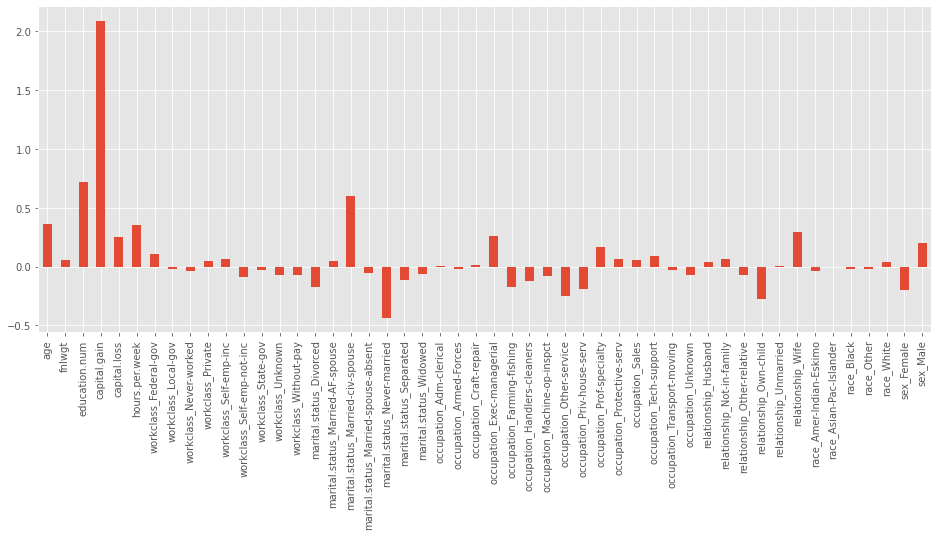

In [54]:
#Plotting it
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(16,6))
weights = pd.Series((model2.coef_[0]),index=df_2.columns)
weights.plot(kind='bar')
plt.show()


## SVM models

+ The linear kernel and the RBF kernel SVM models lead to the same accuracy meaning that we can just select the simpler kernel which leads to less support vectors.

#### RBF Kernel SVM
+ Accuracy of SVM without scaling was 76%

In [57]:
from sklearn.svm import SVC
# train the model just as before
svm_rbf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_rbf.fit(x_train, y_train)  # train object

y_hat = svm_rbf.predict(x_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7578688776293566
[[4927    3]
 [1574    9]]


##### RBF kernel with scaled data
+ As expected the accuracy increased to 85% on the scaled data

In [58]:
# train the model just as before
svm_rbf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_rbf.fit(x_train_scaled, y_train)  # train object

y_hat = svm_rbf.predict(x_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8493781667434362
[[4626  304]
 [ 677  906]]


In [59]:
# look at the support vectors
print(svm_rbf.support_vectors_.shape)
print(svm_rbf.support_.shape)
print(svm_rbf.n_support_ )

(9355, 50)
(9355,)
[4885 4470]


#### Linear Kernel SVM with scaled data
+ The accuracy with the linear kernel was almost the same 85%

In [60]:
from sklearn.svm import SVC

# train the model just as before
svm_lnr = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_lnr.fit(x_train_scaled, y_train)  # train object

y_hat = svm_lnr.predict(x_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8470750806080147
[[4622  308]
 [ 688  895]]


In [61]:
# look at the support vectors
print(svm_lnr.support_vectors_.shape)
print(svm_lnr.support_.shape)
print(svm_lnr.n_support_ )

(8921, 50)
(8921,)
[4469 4452]


### Results for Linear Kernel Model 

##### Plotting the coefficients of the Linear Kernel model with the scaled data
+ The model did well with an accuracy of 85% similar of logistic regression.

###### These variables seem to be the most important
    Capital Gain
    Education Num
    Marital status
    Occupation
    Hours per Week
    
+ These are almost identical results as that of Logistic regression for the most important variables, for the exception the inclusion of Occupation and exclusion of Age in the top 5.
+ Per the Coefficients all of the features do have an effect on income
   

In [67]:
#Printing top 5 weights
weights = svm_lnr.coef_.T # take transpose to make a column vector

# get the list of tuples from two lists.
# and merge them by using zip().
list_of_tuples = list(zip(variable_names, weights))
# Assign data to tuples.
list_of_tuples
# Converting lists of tuples into
# pandas Dataframe.
df3 = pd.DataFrame(list_of_tuples,
                  columns=['feature', 'coef'])
df3.sort_values(by=['coef'], ascending=False).head(5)

,feature,coef
3,capital.gain,[1.780023237104892]
2,education.num,[0.5264629244378276]
17,marital.status_Married-civ-spouse,[0.38405110962153255]
25,occupation_Exec-managerial,[0.24632576882729823]
5,hours.per.week,[0.20024606114619659]


<AxesSubplot:>

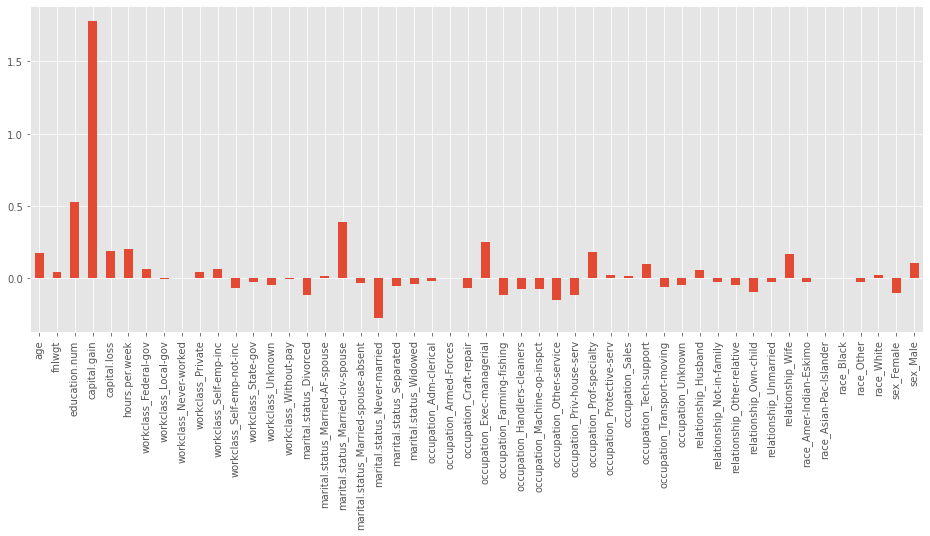

In [68]:
plt.figure(figsize=(16,6))
weights = pd.Series(svm_lnr.coef_[0],index=df_2.columns)
weights.plot(kind='bar')

#### As expected the graphs with of the support vectors do not show as much of a separation as it is selecting the instances on the margin.
#### The support vectors helped with the weights for the features but there is no specific information that can be gathered from the support vectors alone

In [238]:
# Creating Data frame with support vectors from model

# Make a dataframe of the training data
# now get the support vectors from the trained model
df_tested_on= df_new.iloc[train_indices].copy() 
df_support = df_tested_on.iloc[svm_lnr.support_,:].copy()

df_support['income_bool'] = Y[svm_lnr.support_] 
df_new['income_bool'] = Y 


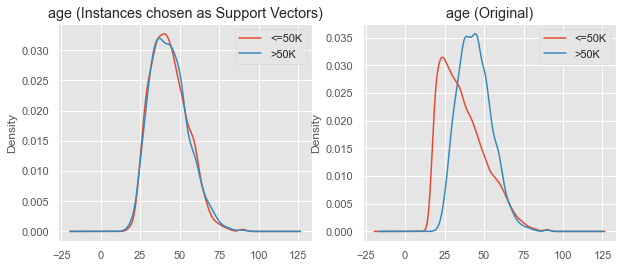

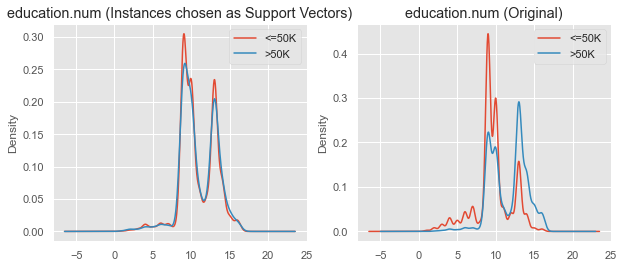

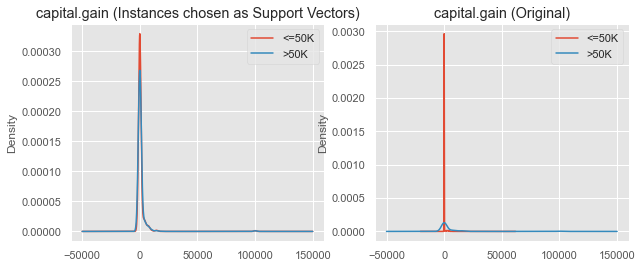

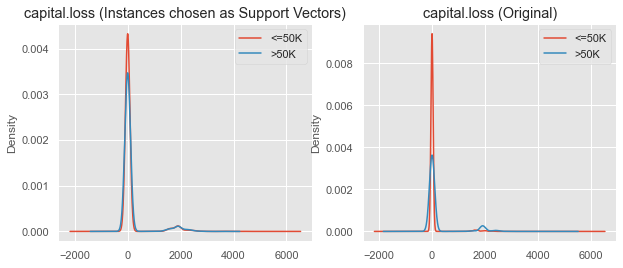

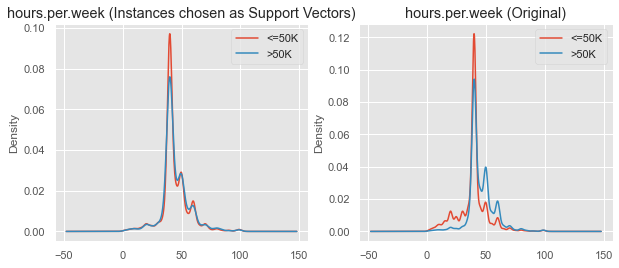

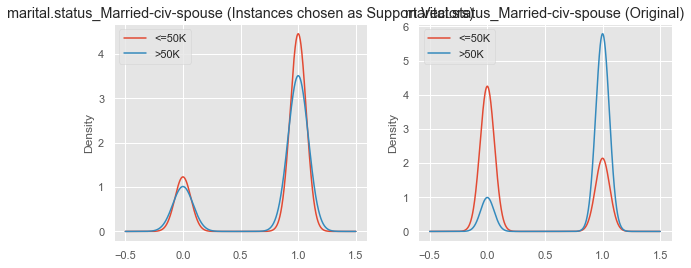

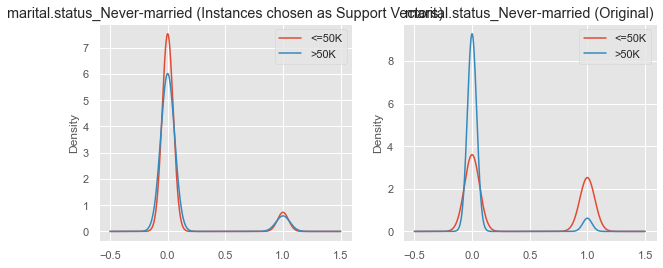

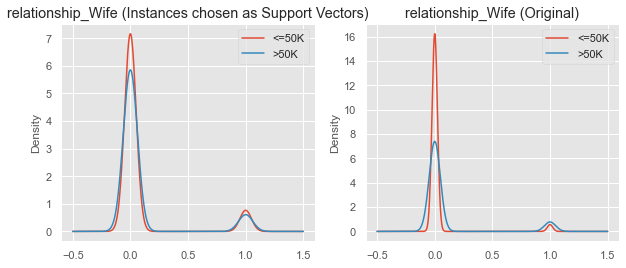

In [240]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['income_bool'])
df_grouped = df_new.groupby(['income_bool'])

# plot KDE
# Selected from the most important variable observed in the model by the support vectors
vars_to_plot = ['age','education.num','capital.gain', 'capital.loss','hours.per.week','marital.status_Married-civ-spouse','marital.status_Never-married','relationship_Wife']


for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Original)')


# Conclusion

#### Support Vector Machine Advantages
+ The support Vector Machine algorithm looks for the optimal distance between the line and the support vectors that separate the classes. This method reduces the risk of having an error. 

+ It includes the capbility of regularisation to penalize weights
+ It allows for handling non linear data
+ Can be used in both Classification and Regression problems.
+ Small changes to data do not affect the model as much so it is stable.
+ Less prone to overfittin than Logistic regression
+ Not affected by outliers because it cares most about points close to decision boundary

#### Support Vector Machine Disadvantages
+ Selecting the correct kernel can be difficult
+ Computationally expesive
+ Difficult to interpret
+ Does not explains the relationship between the response and the explanatory variables


####  Logistic Regresion Advantages
+ Easy to interpret
+ You can obtain the statistics of the model and its coeffcients.
+ Explains the relationship between the response variable and the explanatory variable

#### Logistic Regression Disadvantages
+ Outliers affect model
+ Assumptions need to be met.


+ Both models seems to perfom similarly in terms of prediction. The best model in Logistic regresion lead to 85% accuracy and so did the best model in SVM.
+ SVM is based on geometrical properties of the data while logistic regression is more of a statistical method. Overfitting is less common in SVM than logistic regression.
+ In terms of time the SVM takes much longer to train than the Logistic regression. It is not as efficient when it comes to memory.
